# Лабораторная работа по курсу "Искусственный интеллект"

## Многослойный персептрон

Студент: Аминов Степан

Группа: М8О-408Б-19

Постановка задачи: Решить задачу классификации для датасетов MNIST, FashionMNIST, CIFAR-10 с помощью 1, 2 и 3-слойного персептрона на основе нейросетефого фреймворка Pytorch


In [1]:
from keras.datasets.mnist import load_data as mnist_data
from keras.datasets.fashion_mnist import load_data as fmnist_data
from keras.datasets.cifar10 import load_data as cifar_data
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import time
import os
import matplotlib.pyplot as plt 
import copy
import torchvision
from torchvision import datasets, transforms


## Dataset MNIST

### Один слой

In [2]:
dataloaders = {'train':torch.utils.data.DataLoader(torchvision.datasets.MNIST(root=os.getcwd(),download=True,train=True,
                                                                             
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512),
               'val':torch.utils.data.DataLoader(torchvision.datasets.MNIST(root=os.getcwd(),download=True,train=False,
                                                                           
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512)}
    
    
dataset_sizes = {'train':60000,'val':10000}

In [90]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= 512)
        self.fc2 = nn.Linear(in_features=512,out_features= 512)
        self.fc3 = nn.Linear(in_features=512, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 2.2829 Acc: 0.3653
val Loss: 2.2398 Acc: 0.3800

Epoch 1/7
----------
train Loss: 2.1219 Acc: 0.4675
val Loss: 1.9652 Acc: 0.5777

Epoch 2/7
----------
train Loss: 1.8788 Acc: 0.6318
val Loss: 1.8147 Acc: 0.6661

Epoch 3/7
----------
train Loss: 1.7633 Acc: 0.7586
val Loss: 1.7082 Acc: 0.8124

Epoch 4/7
----------
train Loss: 1.6896 Acc: 0.8194
val Loss: 1.6513 Acc: 0.8688

Epoch 5/7
----------
train Loss: 1.6403 Acc: 0.8690
val Loss: 1.6177 Acc: 0.8848

Epoch 6/7
----------
train Loss: 1.6155 Acc: 0.8812
val Loss: 1.6001 Acc: 0.8931

Epoch 7/7
----------
train Loss: 1.6059 Acc: 0.8865
val Loss: 1.5985 Acc: 0.8930

Training complete in 1m 16s
Best val Acc: 0.893100


### Два слоя

In [7]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= 512)
        self.fc2 = nn.Linear(in_features=512,out_features= 512)
        self.fc3 = nn.Linear(in_features=512,out_features= 1024)

        self.fc4 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))

        x = self.fc4(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 2.0052 Acc: 0.5274
val Loss: 1.6584 Acc: 0.8142

Epoch 1/7
----------
train Loss: 1.6375 Acc: 0.8290
val Loss: 1.6186 Acc: 0.8460

Epoch 2/7
----------
train Loss: 1.6178 Acc: 0.8462
val Loss: 1.6108 Acc: 0.8519

Epoch 3/7
----------
train Loss: 1.6094 Acc: 0.8541
val Loss: 1.6066 Acc: 0.8559

Epoch 4/7
----------
train Loss: 1.6041 Acc: 0.8585
val Loss: 1.6045 Acc: 0.8577

Epoch 5/7
----------
train Loss: 1.5893 Acc: 0.8737
val Loss: 1.5479 Acc: 0.9179

Epoch 6/7
----------
train Loss: 1.5389 Acc: 0.9264
val Loss: 1.5315 Acc: 0.9323

Epoch 7/7
----------
train Loss: 1.5271 Acc: 0.9376
val Loss: 1.5289 Acc: 0.9349

Training complete in 1m 19s
Best val Acc: 0.934900


# Три слоя

In [8]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= 512)
        self.fc2 = nn.Linear(in_features=512,out_features= 512)
        self.fc3 = nn.Linear(in_features=512,out_features= 1024)
        self.fc4 = nn.Linear(in_features=1024,out_features= 1024)


        self.fc5 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 2.2134 Acc: 0.2865
val Loss: 1.8811 Acc: 0.5770

Epoch 1/7
----------
train Loss: 1.7133 Acc: 0.7554
val Loss: 1.6499 Acc: 0.8148

Epoch 2/7
----------
train Loss: 1.6091 Acc: 0.8558
val Loss: 1.5687 Acc: 0.8977

Epoch 3/7
----------
train Loss: 1.5587 Acc: 0.9062
val Loss: 1.5432 Acc: 0.9211

Epoch 4/7
----------
train Loss: 1.5437 Acc: 0.9201
val Loss: 1.5356 Acc: 0.9280

Epoch 5/7
----------
train Loss: 1.5323 Acc: 0.9311
val Loss: 1.5266 Acc: 0.9368

Epoch 6/7
----------
train Loss: 1.5237 Acc: 0.9398
val Loss: 1.5213 Acc: 0.9422

Epoch 7/7
----------
train Loss: 1.5141 Acc: 0.9495
val Loss: 1.5144 Acc: 0.9478

Training complete in 1m 22s
Best val Acc: 0.947800


# Fmnist

In [18]:
dataloaders = {'train':torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root=os.getcwd(),download=True,train=True,
                                                                             
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512),
               'val':torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root=os.getcwd(),download=True,train=False,
                                                                           
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512)}
    
    
dataset_sizes = {'train':60000,'val':10000}

# один слой 

In [22]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= 1024)
        self.fc2 = nn.Linear(in_features=1024,out_features= 2048)
        self.fc3 = nn.Linear(in_features=2048, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.5, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 2.0847 Acc: 0.6831
val Loss: 2.0423 Acc: 0.7726

Epoch 1/29
----------
train Loss: 2.0309 Acc: 0.8159
val Loss: 2.0274 Acc: 0.8241

Epoch 2/29
----------
train Loss: 2.0230 Acc: 0.8347
val Loss: 2.0271 Acc: 0.8252

Epoch 3/29
----------
train Loss: 2.0183 Acc: 0.8460
val Loss: 2.0232 Acc: 0.8374

Epoch 4/29
----------
train Loss: 2.0154 Acc: 0.8516
val Loss: 2.0223 Acc: 0.8319

Epoch 5/29
----------
train Loss: 2.0138 Acc: 0.8567
val Loss: 2.0188 Acc: 0.8455

Epoch 6/29
----------
train Loss: 2.0124 Acc: 0.8602
val Loss: 2.0172 Acc: 0.8486

Epoch 7/29
----------
train Loss: 2.0082 Acc: 0.8693
val Loss: 2.0150 Acc: 0.8533

Epoch 8/29
----------
train Loss: 2.0077 Acc: 0.8709
val Loss: 2.0147 Acc: 0.8557

Epoch 9/29
----------
train Loss: 2.0073 Acc: 0.8718
val Loss: 2.0146 Acc: 0.8566

Epoch 10/29
----------
train Loss: 2.0070 Acc: 0.8722
val Loss: 2.0145 Acc: 0.8575

Epoch 11/29
----------
train Loss: 2.0067 Acc: 0.8728
val Loss: 2.0143 Acc: 0.8582

Epoch 12/29
----------
t

# два слоя 


In [35]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= 512)
        self.fc2 = nn.Linear(in_features=512,out_features= 512)
        self.fc3 = nn.Linear(in_features=512,out_features= 1024)

        self.fc4 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.fc4(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1, momentum=0.4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 1.9034 Acc: 0.5767
val Loss: 1.7642 Acc: 0.6994

Epoch 1/29
----------
train Loss: 1.6891 Acc: 0.7741
val Loss: 1.6963 Acc: 0.7667

Epoch 2/29
----------
train Loss: 1.6682 Acc: 0.7945
val Loss: 1.6505 Acc: 0.8119

Epoch 3/29
----------
train Loss: 1.6437 Acc: 0.8179
val Loss: 1.6506 Acc: 0.8122

Epoch 4/29
----------
train Loss: 1.6307 Acc: 0.8307
val Loss: 1.6757 Acc: 0.7852

Epoch 5/29
----------
train Loss: 1.6233 Acc: 0.8382
val Loss: 1.6709 Acc: 0.7902

Epoch 6/29
----------
train Loss: 1.6200 Acc: 0.8412
val Loss: 1.6387 Acc: 0.8214

Epoch 7/29
----------
train Loss: 1.6016 Acc: 0.8595
val Loss: 1.6169 Acc: 0.8449

Epoch 8/29
----------
train Loss: 1.5985 Acc: 0.8637
val Loss: 1.6158 Acc: 0.8454

Epoch 9/29
----------
train Loss: 1.5971 Acc: 0.8652
val Loss: 1.6149 Acc: 0.8458

Epoch 10/29
----------
train Loss: 1.5959 Acc: 0.8664
val Loss: 1.6139 Acc: 0.8464

Epoch 11/29
----------
train Loss: 1.5949 Acc: 0.8676
val Loss: 1.6132 Acc: 0.8467

Epoch 12/29
----------
t

# Три слоя 

In [43]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= 512)
        self.fc2 = nn.Linear(in_features=512,out_features= 512)
        self.fc3 = nn.Linear(in_features=512,out_features= 1024)
        self.fc4 = nn.Linear(in_features=1024,out_features= 1024)


        self.fc5 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=2, momentum=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.01)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 1.9971 Acc: 0.4760
val Loss: 1.8119 Acc: 0.6470

Epoch 1/29
----------
train Loss: 1.7242 Acc: 0.7369
val Loss: 1.9052 Acc: 0.5533

Epoch 2/29
----------
train Loss: 1.6810 Acc: 0.7797
val Loss: 1.7133 Acc: 0.7462

Epoch 3/29
----------
train Loss: 1.6580 Acc: 0.8028
val Loss: 1.6434 Acc: 0.8171

Epoch 4/29
----------
train Loss: 1.6445 Acc: 0.8164
val Loss: 1.6474 Acc: 0.8130

Epoch 5/29
----------
train Loss: 1.6387 Acc: 0.8220
val Loss: 1.6565 Acc: 0.8037

Epoch 6/29
----------
train Loss: 1.6317 Acc: 0.8290
val Loss: 1.7577 Acc: 0.7029

Epoch 7/29
----------
train Loss: 1.6367 Acc: 0.8239
val Loss: 1.6825 Acc: 0.7776

Epoch 8/29
----------
train Loss: 1.6292 Acc: 0.8314
val Loss: 1.7575 Acc: 0.7038

Epoch 9/29
----------
train Loss: 1.6256 Acc: 0.8353
val Loss: 1.6275 Acc: 0.8332

Epoch 10/29
----------
train Loss: 1.6200 Acc: 0.8403
val Loss: 1.6233 Acc: 0.8373

Epoch 11/29
----------
train Loss: 1.6208 Acc: 0.8398
val Loss: 1.6487 Acc: 0.8129

Epoch 12/29
----------
t

# CIFAR10

In [91]:
dataloaders = {'train':torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root=os.getcwd(),download=True,train=True,
                                                                             
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=30),
               'val':torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root=os.getcwd(),download=True,train=False,
                                                                           
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=30)}
    
    
dataset_sizes = {'train':50000,'val':10000}

Files already downloaded and verified
Files already downloaded and verified


# Один слой

In [92]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3,out_features= 6144)
        self.fc2 = nn.Linear(in_features=6144,out_features= 6144)
        self.fc3 = nn.Linear(in_features=6144, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,32*32*3)
        x = self.fc1(x)
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=1, momentum=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 2.3517 Acc: 0.1079
val Loss: 2.3389 Acc: 0.1222

Epoch 1/7
----------
train Loss: 2.3507 Acc: 0.1104
val Loss: 2.3612 Acc: 0.1000

Epoch 2/7
----------
train Loss: 2.3611 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 3/7
----------
train Loss: 2.3611 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 4/7
----------
train Loss: 2.3611 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 5/7
----------
train Loss: 2.3611 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 6/7
----------
train Loss: 2.3611 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 7/7
----------
train Loss: 2.3611 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Training complete in 7m 56s
Best val Acc: 0.122200


# Два слоя 

In [93]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3,out_features= 512)
        self.fc2 = nn.Linear(in_features=512,out_features= 512)
        self.fc3 = nn.Linear(in_features=512,out_features= 1024)

        self.fc4 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,32*32*3)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))

        x = self.fc4(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 2.3264 Acc: 0.1293
val Loss: 2.3609 Acc: 0.1002

Epoch 1/7
----------
train Loss: 2.3389 Acc: 0.1220
val Loss: 2.3608 Acc: 0.1004

Epoch 2/7
----------
train Loss: 2.3605 Acc: 0.1006
val Loss: 2.3612 Acc: 0.1000

Epoch 3/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 4/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 5/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 6/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 7/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Training complete in 2m 11s
Best val Acc: 0.100400


# Три слоя

In [94]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3,out_features= 512)
        self.fc2 = nn.Linear(in_features=512,out_features= 512)
        self.fc3 = nn.Linear(in_features=512,out_features= 1024)
        self.fc4 = nn.Linear(in_features=1024,out_features= 1024)


        self.fc5 = nn.Linear(in_features=1024, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,32*32*3)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)

        return F.softmax(x)


    
model_ft = MyConvNet()


model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=8)

Epoch 0/7
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 2.3000 Acc: 0.1500
val Loss: 2.3610 Acc: 0.1002

Epoch 1/7
----------
train Loss: 2.3608 Acc: 0.1003
val Loss: 2.3608 Acc: 0.1003

Epoch 2/7
----------
train Loss: 2.3607 Acc: 0.1004
val Loss: 2.3609 Acc: 0.1003

Epoch 3/7
----------
train Loss: 2.3607 Acc: 0.1005
val Loss: 2.3609 Acc: 0.1003

Epoch 4/7
----------
train Loss: 2.3522 Acc: 0.1088
val Loss: 2.3612 Acc: 0.1000

Epoch 5/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 6/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Epoch 7/7
----------
train Loss: 2.3612 Acc: 0.1000
val Loss: 2.3612 Acc: 0.1000

Training complete in 2m 28s
Best val Acc: 0.100300


# Перебор параметров сетей 

In [95]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        #print(f'Epoch {epoch}/{num_epochs - 1}')
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.cuda()
                labels = labels.cuda()
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #print(outputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val':

              history.append(float(epoch_acc))
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = float(epoch_acc)
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    #print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    #print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return history,best_acc ,model

## MNIST MultiLayer Perceptron

In [96]:
dataloaders = {'train':torch.utils.data.DataLoader(torchvision.datasets.MNIST(root=os.getcwd(),download=True,train=True,
                                                                             
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512),
               'val':torch.utils.data.DataLoader(torchvision.datasets.MNIST(root=os.getcwd(),download=True,train=False,
                                                                           
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512)}
    
    
dataset_sizes = {'train':60000,'val':10000}





import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self,n_hidden):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden,out_features= n_hidden)
        self.fc3 = nn.Linear(in_features=n_hidden,out_features= n_hidden)
        self.fc4 = nn.Linear(in_features=n_hidden,out_features= n_hidden)


        self.fc5 = nn.Linear(in_features=n_hidden, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)

        return F.softmax(x)



hiddens_neurons = [10, 50, 100, 150, 250,500]
accs = []
historys = []
for i in hiddens_neurons:

  model_ft = MyConvNet(n_hidden=i)


  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  history, acc,model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=8)
  accs.append(acc)
  historys.append(history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


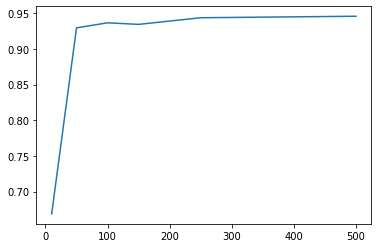

In [97]:
# Зависимость точности от количества нейроннов 
import matplotlib.pyplot as plt
plt.plot(hiddens_neurons,accs)

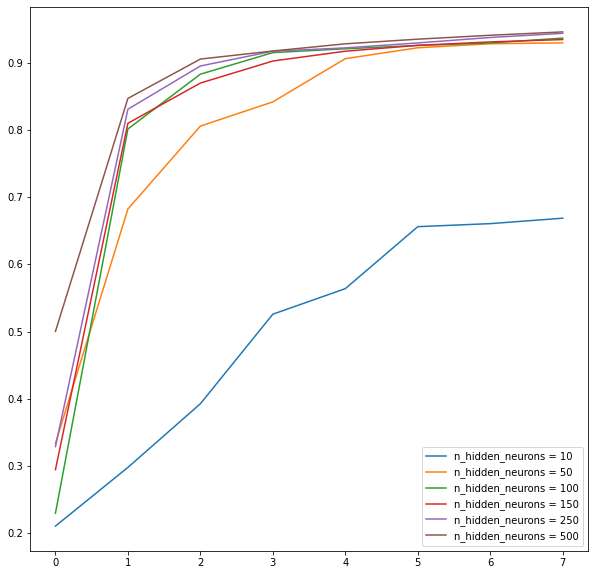

In [100]:
plt.figure(figsize=(10,10))
for i in range(len(historys)):
  plt.plot([k for k in range(8)],historys[i],label=f'n_hidden_neurons = {hiddens_neurons[i]}')
plt.legend()

Смотря на графики можно сделать вывод, что после 100 нейронов в каждом скрытом слое  точность не особо сильно возрастает. Касательно второго графика хочется заметить, что сеть с 500 нейронами в каждом скрытом слое на каждой эпохе достигает лучшей метрики. При этом начиная примерно с 3 эпохи рост метрики значительно замедляется для все сетей с количеством нейронов в скрытых слоях равных 100, 150, 250, 500. В конце хочется заметить, что большая часть рассмотренных сетей достигают неплохого показателя метрики. Это указывает на неплохую применимость архитектуры перцептронов для решения задачи классификация датасета MNIST

## Fmnist MultiLayer Perceptron

In [108]:
dataloaders = {'train':torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root=os.getcwd(),download=True,train=True,
                                                                             
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512),
               'val':torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST(root=os.getcwd(),download=True,train=False,
                                                                           
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=512)}
    
    
dataset_sizes = {'train':60000,'val':10000}

In [109]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self,n_hidden):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28,out_features= n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden,out_features= n_hidden)
        self.fc3 = nn.Linear(in_features=n_hidden,out_features= n_hidden)
        self.fc4 = nn.Linear(in_features=n_hidden,out_features= n_hidden)


        self.fc5 = nn.Linear(in_features=n_hidden, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,28*28)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)

        return F.softmax(x)



hiddens_neurons = [10, 50, 100, 150, 250,500]
accs = []
historys = []
for i in hiddens_neurons:

  model_ft = MyConvNet(n_hidden=i)


  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  history, acc,model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=8)
  accs.append(acc)
  historys.append(history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


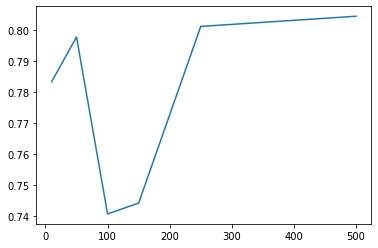

In [110]:
# Зависимость точности от количества нейроннов 
import matplotlib.pyplot as plt
plt.plot(hiddens_neurons,accs)

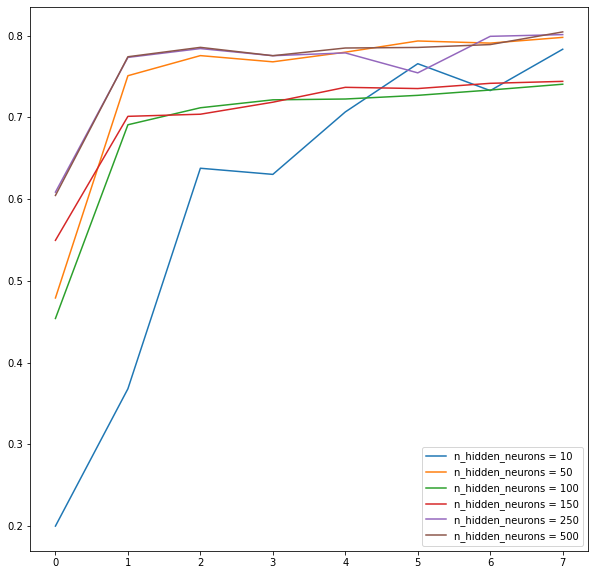

In [111]:
plt.figure(figsize=(10,10))
for i in range(len(historys)):
  plt.plot([k for k in range(8)],historys[i],label=f'n_hidden_neurons = {hiddens_neurons[i]}')
plt.legend()

Смотря на графики можно сделать вывод, что почему от 100 до 150 нейронов наблюдается падения метрики. Это действительно странная аномалия(не критично падает, но все-таки падает). При этом далее от 200 до 500 нейронов идет постепенный медленный рост метрики.  Касательно второго графика хочется заметить, что сеть с 500 нейронами в каждом скрытом слое на каждой эпохе достигает лучшей метрики. При этом начиная примерно с 1 эпохи рост метрики значительно замедляется для все сетей с количеством нейронов в скрытых слоях равных 50,100, 150, 250, 500. В конце хочется заметить, что большая часть рассмотренных сетей достигают неплохого показателя метрики. Это указывает на неплохую применимость архитектуры перцептронов для решения задачи классификация датасета Fmnist

# CIFAR10

In [112]:
dataloaders = {'train':torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root=os.getcwd(),download=True,train=True,
                                                                             
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=30),
               'val':torch.utils.data.DataLoader(torchvision.datasets.CIFAR10(root=os.getcwd(),download=True,train=False,
                                                                           
                                                  transform=transforms.Compose([
                                                              transforms.ToTensor()])),batch_size=30)}
    
    
dataset_sizes = {'train':50000,'val':10000}

Files already downloaded and verified
Files already downloaded and verified


In [116]:

import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class MyConvNet(nn.Module):
    def __init__(self,n_hidden):
        super(MyConvNet, self).__init__()
        self.fc1 = nn.Linear(in_features=32*32*3,out_features= n_hidden)
        self.fc2 = nn.Linear(in_features=n_hidden,out_features= n_hidden)
        self.fc3 = nn.Linear(in_features=n_hidden,out_features= n_hidden)
        self.fc4 = nn.Linear(in_features=n_hidden,out_features= n_hidden)


        self.fc5 = nn.Linear(in_features=n_hidden, out_features=10)
        
    def forward(self, x):
        x = x.view(-1,32*32*3)
        x = self.fc1(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)

        return F.softmax(x)



hiddens_neurons = [10, 50, 100, 150, 250,500]
accs = []
historys = []
for i in hiddens_neurons:

  model_ft = MyConvNet(n_hidden=i)


  model_ft = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
  optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.1, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
  history, acc,model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=30)
  accs.append(acc)
  historys.append(history)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


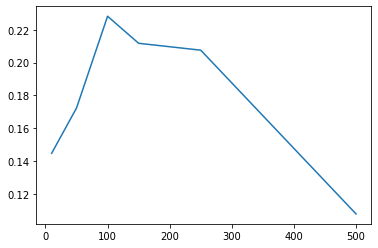

In [117]:
# Зависимость точности от количества нейроннов 
import matplotlib.pyplot as plt
plt.plot(hiddens_neurons,accs)

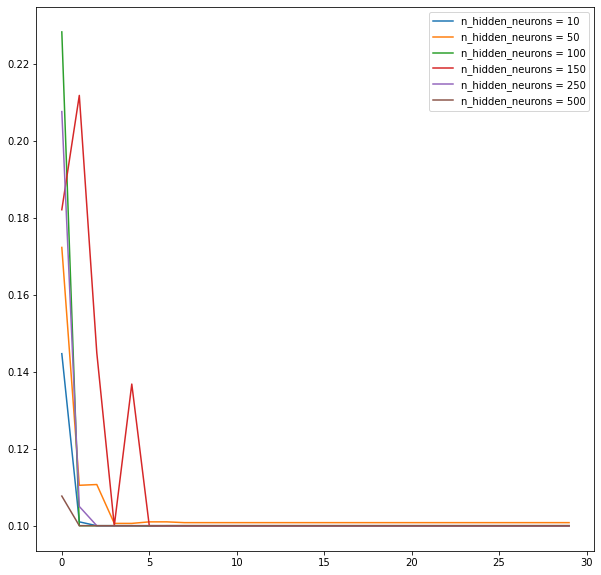

In [119]:
plt.figure(figsize=(10,10))
for i in range(len(historys)):
  plt.plot([k for k in range(30)],historys[i],label=f'n_hidden_neurons = {hiddens_neurons[i]}')
plt.legend()

Для датасета CIFAR10 лучший показатель метрики достигается при количестве нейронов в каждом скрытом слое равном 100. Касательно зависимости метрики от количества эпох обучения хочется заметить, что метрика начинает уменьшаться после 1-3 эпох. Данный факт может говорить о возможном переобучении модели. Также метрика достигает всего-то 0.22 максимально. Это указывает о плохом потенциале использования архитектуры перцептрона для решения задачи кларификации датасета CIFAR10. Метрику могло бы поднять добавление сверхточных слоев и макспулингов.